## **Dataset preparation**

In [69]:
import os
import pandas as pd

# Paths
base_dir = '/media/dillibabu/PortableSSD/Exp/capri6_rootcause_data/glitchsweep_fsm_red'
csv_file_path = os.path.join(base_dir, 'f_core_4_values.csv')
signal_file_path = os.path.join(base_dir, 'processor.txt')
output_csv_path = os.path.join(base_dir, 'tb_13cc_c4_mapped_signals_output.csv')

# Function to load signal names from the processor.txt file
def load_signal_names(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file if line.strip()]

# Load signal names from processor.txt
signal_names = load_signal_names(signal_file_path)

# Load groundtruth_core_0_values.csv
df = pd.read_csv(csv_file_path, header=None)

# Ensure the number of signal names matches the number of columns (660)
expected_bit_count = len(signal_names)

# Ensure the number of columns matches the number of signal names
if df.shape[1] != expected_bit_count:
    raise ValueError(f"Expected {expected_bit_count} bits per row, but got {df.shape[1]} bits.")

# Create a new DataFrame with signal names as the index and values from CSV as columns
mapped_df = pd.DataFrame(data=df.values.T, index=signal_names)

# Save the mapped data to a new CSV file
mapped_df.to_csv(output_csv_path, header=False)

print(f"Mapped signal data has been saved to {output_csv_path}")


Mapped signal data has been saved to /media/dillibabu/PortableSSD/Exp/capri6_rootcause_data/glitchsweep_fsm_red/tb_13cc_c4_mapped_signals_output.csv


0            watchdog_0.wdtctl_reg_7_.Q;
1            watchdog_0.wdtctl_reg_6_.Q;
2            watchdog_0.wdtctl_reg_4_.Q;
3            watchdog_0.wdtctl_reg_2_.Q;
4            watchdog_0.wdtctl_reg_1_.Q;
                     ...                
654     clock_module_0.bcsctl1_reg_4_.Q;
655        clock_module_0.aclk_en_reg.Q;
656    clock_module_0.aclk_div_reg_2_.Q;
657    clock_module_0.aclk_div_reg_1_.Q;
658    clock_module_0.aclk_div_reg_0_.Q;
Name: 0, Length: 659, dtype: object
First difference occurs at clock cycle: 6
Difference at Bit Index 149 with Signal: frontend_0.pc_reg_2_.Q;
Difference at Bit Index 150 with Signal: frontend_0.pc_reg_1_.Q;
Difference at Bit Index 161 with Signal: frontend_0.inst_src_bin_reg_3_.Q;
Difference at Bit Index 162 with Signal: frontend_0.inst_src_bin_reg_2_.Q;
Difference at Bit Index 163 with Signal: frontend_0.inst_src_bin_reg_1_.Q;
Difference at Bit Index 164 with Signal: frontend_0.inst_src_bin_reg_0_.Q;
Difference at Bit Index 189 with Signal: 

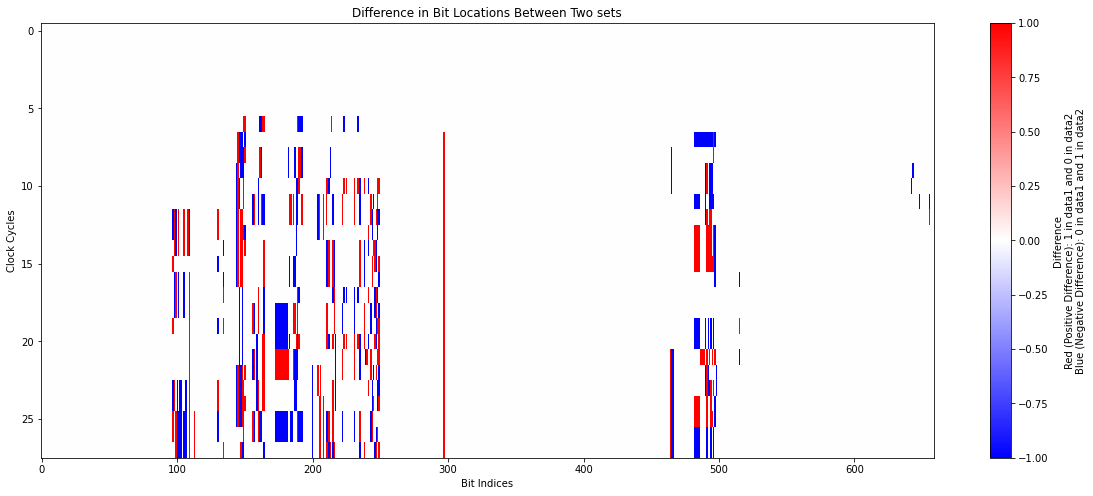

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

train_file_path = '/media/dillibabu/PortableSSD/Exp/capri6_rootcause_data/glitchsweep_fsm_red/mapped_signals_output.csv'
validate_file_path = '/media/dillibabu/PortableSSD/Exp/capri6_rootcause_data/glitchsweep_fsm_red/tb_13cc_c5_mapped_signals_output.csv'

# Read the CSV files, skipping the first row which contains signal names and spaces
data1 = pd.read_csv(train_file_path, skiprows=1, header=None)
data2 = pd.read_csv(validate_file_path, skiprows=1, header=None)

# Extract signal names (first column)
signal_names = data1.iloc[:, 0]
print(signal_names)
# Exclude the first column (signal names) to get the numeric data
numeric_data1 = data1.iloc[:, 1:].astype(int)
numeric_data2 = data2.iloc[:, 1:].astype(int)
#print('numeric_data1',numeric_data1)
#print('numeric_data2',numeric_data2)
# Calculate the difference
difference = numeric_data1 - numeric_data2

# Identify the first clock cycle where a difference occurs
diff_matrix = (difference.T != 0)
first_diff_cycle = np.argmax(diff_matrix.values.any(axis=1))

# Print the first clock cycle where a difference occurs
print(f"First difference occurs at clock cycle: {first_diff_cycle}")

# Identify the bit index positions and corresponding signal names where differences occur
bit_diff_indices = np.where(diff_matrix.iloc[first_diff_cycle].values)[0]
bit_diff_signal_names = signal_names.T[bit_diff_indices]

# Print the differences in bit index positions and corresponding signal names
for idx, signal_name in zip(bit_diff_indices, bit_diff_signal_names):
    print(f"Difference at Bit Index {idx} with Signal: {signal_name}")

# Plot the difference with Bit Index on x-axis and Clock Cycle on y-axis
plt.figure(figsize=(20, 8))
im = plt.imshow(difference.T, cmap='bwr', aspect='auto', interpolation='none')

cbar = plt.colorbar(im)
cbar.set_label('Difference\nRed (Positive Difference): 1 in data1 and 0 in data2\nBlue (Negative Difference): 0 in data1 and 1 in data2')
plt.xlabel('Bit Indices')
plt.ylabel('Clock Cycles')
plt.title('Difference in Bit Locations Between Two sets')

# Display the plot
plt.show()


In [76]:
import pandas as pd
import numpy as np
import re

def bits_to_hex(bits):
    # Convert the list of bits to a string
    bit_str = ''.join(str(bit) for bit in bits)
    # Convert the binary string to a hexadecimal string
    hex_value = hex(int(bit_str, 2))[2:].upper()  # [2:] to remove '0x' prefix and upper to capitalize
    return hex_value.zfill(len(bits) // 4)  # Ensure correct padding for the hex value

# Define the set of modules we're interested in
modules_of_interest = {
    'clock_module_0', 'dbg_0', 'execution_unit_0',
    'frontend_0', 'mem_backbone_0', 'multiplier_0',
    'sfr_0', 'watchdog_0'
}

# Function to classify the signal
def classify_signal(signal_name):
    match = re.match(r'^[^.]+\.', signal_name)
    if not match:
        return None
    
    module_name = match.group(0)[:-1]  # Remove the trailing dot
    
    if module_name not in modules_of_interest:
        return None
    
    remaining_components = signal_name[len(module_name) + 1:]
    
    sub_module = re.match(r'^[^.]+\.', remaining_components)
    if not sub_module:
        return None
    
    sub_module_name = sub_module.group(0)[:-1]  # Remove the trailing dot
    
    if sub_module_name[-1] == '_':
        if re.match(r'.*_\d+_$', sub_module_name):
            classified_name = sub_module_name[:-3] if sub_module_name[-3] == '_' else sub_module_name[:-4]
        else:
            classified_name = sub_module_name
    elif sub_module_name[-1] == 'g':
        classified_name = sub_module_name
    elif sub_module_name[-1] == '0':
        last_components = signal_name[len(module_name + sub_module_name) + 2:]
        inner_remaining = re.match(r'^[^.]+\.', last_components)
        if not inner_remaining:
            return None
        
        inner_remaining_name = inner_remaining.group(0)[:-1]
        
        if inner_remaining_name[-1] == '_':
            if re.match(r'.*_\d+_$', inner_remaining_name):
                classified_inner_remaining_name = inner_remaining_name[:-3] if inner_remaining_name[-3] == '_' else inner_remaining_name[:-4]
        else:
            classified_inner_remaining_name = inner_remaining_name
        
        classified_name = f"{sub_module_name}.{classified_inner_remaining_name}"
    else:
        classified_name = sub_module_name
    
    return f"{module_name}.{classified_name}"

# Load the datasets
train_file_path = '/media/dillibabu/PortableSSD/Exp/capri6_rootcause_data/glitchsweep_fsm_red/mapped_signals_output.csv'
validate_file_path = '/media/dillibabu/PortableSSD/Exp/capri6_rootcause_data/glitchsweep_fsm_red/tb_13cc_c5_mapped_signals_output.csv'

# Read the CSV files, skipping the first row which contains signal names and spaces
data1 = pd.read_csv(train_file_path, skiprows=1, header=None)
data2 = pd.read_csv(validate_file_path, skiprows=1, header=None)

# Extract signal names (first column)
signal_names = data1.iloc[:, 0]

# Exclude the first column (signal names) to get the numeric data
numeric_data1 = data1.iloc[:, 1:].astype(int).T
numeric_data2 = data2.iloc[:, 1:].astype(int).T

# Calculate the difference
difference = numeric_data1 - numeric_data2

# Identify the first clock cycle where a difference occurs
diff_matrix = (difference != 0)
first_diff_cycle = np.argmax(diff_matrix.any(axis=1))

second_diff_cycle = first_diff_cycle + 1
for diff_cc in range(first_diff_cycle, second_diff_cycle + 1):
    
    #=================================================
    # Print the first clock cycle where a difference occurs
    print(f"============difference occurs at clock cycle: {diff_cc+7}============\n")

    # Identify the bit index positions and corresponding signal names where differences occur
    bit_diff_indices = np.where(diff_matrix.iloc[diff_cc].values)[0]
    bit_diff_signal_names = signal_names.iloc[bit_diff_indices]

    # Initialize a dictionary to hold the categorized signals
    categorized_signals = {}

    # Loop through the signal names with differences to categorize them
    for signal_name in bit_diff_signal_names:
        classified_name = classify_signal(signal_name)

        if classified_name:
            if classified_name not in categorized_signals:
                categorized_signals[classified_name] = []
            categorized_signals[classified_name].append(signal_name)

    # Now filter out only the categories that had differences
    filtered_categories = {category: signals for category, signals in categorized_signals.items()}

    # Print the categorized signals and extract bits for each filtered category
    for category, signals in filtered_categories.items():
        print(f"\nCategory: {category}")

        # Collect all related signals for the category
        related_signals = [sig for sig in signal_names if classify_signal(sig) == category]
        indices = signal_names[signal_names.isin(related_signals)].index

        # Extract the corresponding bits from both datasets
        bits_from_numeric_data1 = numeric_data1.iloc[diff_cc, indices].values
        bits_from_numeric_data2 = numeric_data2.iloc[diff_cc, indices].values

        # Convert bits to hex
        hex_non_faulty = bits_to_hex(bits_from_numeric_data1)
        hex_faulty = bits_to_hex(bits_from_numeric_data2)

        # Print the extracted bits with their hexadecimal equivalent
        print(f"Non-faulty core : {category}: {bits_from_numeric_data1.tolist()} = [{hex_non_faulty}]")
        print(f"Faulty core : {category}: {bits_from_numeric_data2.tolist()} = [{hex_faulty}]")


============difference occurs at clock cycle: 13============


Category: frontend_0.pc_reg
Non-faulty core : frontend_0.pc_reg: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0] = [F03E]
Faulty core : frontend_0.pc_reg: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0] = [F038]

Category: frontend_0.inst_src_bin_reg
Non-faulty core : frontend_0.inst_src_bin_reg: [0, 0, 1, 1] = [3]
Faulty core : frontend_0.inst_src_bin_reg: [1, 1, 0, 0] = [C]

Category: frontend_0.inst_mov_reg
Non-faulty core : frontend_0.inst_mov_reg: [1] = [1]
Faulty core : frontend_0.inst_mov_reg: [0] = [0]

Category: frontend_0.inst_jmp_bin_reg
Non-faulty core : frontend_0.inst_jmp_bin_reg: [0, 0, 0] = [0]
Faulty core : frontend_0.inst_jmp_bin_reg: [1, 1, 1] = [7]

Category: frontend_0.inst_bw_reg
Non-faulty core : frontend_0.inst_bw_reg: [1] = [1]
Faulty core : frontend_0.inst_bw_reg: [0] = [0]

Category: frontend_0.inst_alu_reg
Non-faulty core : frontend_0.inst_alu_reg: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] = [000]
F